Análise da Situação dos Municípios Brasileiros quanto ao cumprimento dos itens avaliados pela Lei de Responsabilidade Fiscal

Modelos de Classificação

1) Importação das Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import datetime 
from datetime import timedelta 
import time
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.cluster import KMeans as kmeans
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score as silhouette
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics as sk_metrics
from sklearn.metrics import classification_report
import itertools
import warnings
warnings.filterwarnings('ignore')

2) Matrix de Confusão

In [ ]:
def plot_confusion_matrix(cm, classes,normalize=False,cmap=plt.cm.Blues):
  title='Matrix de Confusão'
  try:
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Valores verdadeiros')
    plt.xlabel('Preditos')
    plt.tight_layout()
  except Exception as err:
    print('Erro ao plotar grafico: {0}'.format(err))

3) Leitura do Dataset gerado

In [15]:
dfr_fpm = pd.read_csv('dfr_fpm.csv',sep=',')
dfr_fpm.replace(np.nan,0,inplace=True)
print('Total de registros:{0}'.format(len(dfr_fpm)))
dfr_fpm.head()

Total de registros:5569


,cod_mun_ent,uf,nom_municipio_x,1.1,1.3,1.4,1.5,2.1.1,2.1.2,3.1,3.2.2,3.2.3,3.3,3.4,3.5,4.1,4.2,4.3,4.4,qtd_2018_x,Região,idhm,idhm_renda,soma_capag,media_indicadores,mediana_indicadores,sit_obr
0,520005.0,GO,Abadia de Goi�s,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,8583,CO,0.708,0.687,1.9967,0.665567,0.9063,1.0
1,310010.0,MG,Abadia dos Dourados,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6972,SE,0.689,0.693,1.8503,0.616767,0.7747,0.0
2,520010.0,GO,Abadi�nia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19614,CO,0.689,0.671,2.9462,0.982067,0.9592,0.0
3,310020.0,MG,Abaet�,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23223,SE,0.698,0.720,1.3460,0.448667,0.3102,0.0
4,150010.0,PA,Abaetetuba,2.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0,2.0,156292,N,0.628,0.579,0.0000,0.000000,0.0000,2.0


4) Seleção das colunas utilizadas no Modelo

In [16]:
cols = ['cod_mun_ent',
'1.1',
'1.3',
'1.4',
'1.5',
'2.1.1',
'2.1.2',
'3.1',
'3.2.2',
'3.2.3',
'3.3',
'3.4',
'3.5',
'4.1',
'4.2',
'4.3',
'4.4',
'qtd_2018_x', #populacao       
'idhm',
#'idhm_renda',
#'soma_capag',        
#'media_indicadores',
#'mediana_indicadores',
'sit_obr']

y = dfr_fpm ['sit_obr']
x = dfr_fpm [cols[1:-1]]

5) Declaração dos Modelos utilizados no experimento

In [17]:
k_fold = 5
models      = []
results     = []
names       = []
models.append(('NB',        MultinomialNB())) 
models.append(('LR',        LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=1024)))
models.append(('OneVsRest', OneVsRestClassifier(LinearSVC(random_state=1024))))

6) Cross Validation

In [18]:
X_train,x_test,Y_train,y_test = train_test_split(x,y,shuffle=True,random_state = 1024)

7) Treinamento

In [19]:
print('Inicio do Treino...')
#df_x_train_vec = pd.DataFrame(x_train_vec.toarray(), columns=vectorizer.get_feature_names())
k_fold=5
start=time.time() 
for nme_model, model in models:
  model.fit(X_train,Y_train)
  metrics_k_fold = cross_val_score(model, X_train, Y_train, cv=k_fold, scoring='f1_macro')   
  elapsed = time.time() - start
  results.append(metrics_k_fold)
  names.append(nme_model)
  print('Modelo:{0} Média :{1}  STD:{2} Tempo execucao:{3}'.format(nme_model.ljust(16,' '),round(metrics_k_fold.mean(),5),round(metrics_k_fold.std(),5),round(elapsed,4)))  
print('Fim do Treino - Tempo gasto:{0}'.format(time.time() - start))

Inicio do Treino...
Modelo:NB               Média :0.67366  STD:0.005 Tempo execucao:0.0524
Modelo:LR               Média :0.98025  STD:0.01338 Tempo execucao:10.5208
Modelo:OneVsRest        Média :0.24405  STD:0.03221 Tempo execucao:13.7521
Fim do Treino - Tempo gasto:13.753047704696655


8) Teste

In [20]:
metric=[]
start = time.time()
for name, model in models:
  y = model.predict(x_test)
  score = round(f1_score(y_test, y, pos_label=1, average='macro'),4)  
  elapsed = time.time() - start
  metric.append(score)
  print('Modelo:{0}  Score:{1}  Tempo execucao:{2}'.format(name.ljust(20,' '),round(score,5),round(elapsed,4)))

Modelo:NB                    Score:0.6996  Tempo execucao:0.008
Modelo:LR                    Score:1.0  Tempo execucao:0.0127
Modelo:OneVsRest             Score:0.2343  Tempo execucao:0.0195


9) Avaliação do Modelo por meio da Técnica Naive Bayes

In [21]:
model=models[0][1]
model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

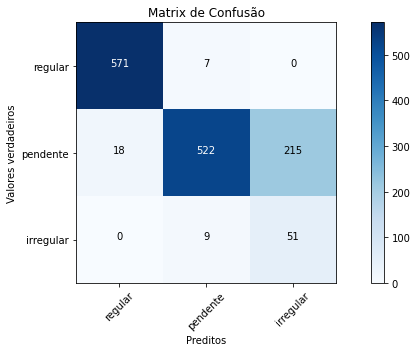

In [22]:
fig = plt.figure(figsize=(10, 5)) 
yp = model.predict(x_test)
cm=confusion_matrix(y_test, yp)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm, classes=['regular', 'pendente', 'irregular'])

In [23]:
print(classification_report(y_test, yp))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       578
         1.0       0.97      0.69      0.81       755
         2.0       0.19      0.85      0.31        60

    accuracy                           0.82      1393
   macro avg       0.71      0.84      0.70      1393
weighted avg       0.94      0.82      0.86      1393



10) Avaliação do Modelo por meio da Técnica Regressão Logística

In [24]:
model=models[1][1]
model

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=-1,
                   penalty='l2', random_state=1024, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

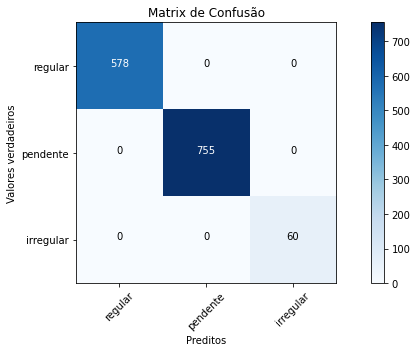

In [25]:
fig = plt.figure(figsize=(10, 5)) 
yp = model.predict(x_test)
cm = confusion_matrix(y_test, yp)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm, classes=['regular', 'pendente', 'irregular'])

In [27]:
print(classification_report(y_test, yp))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       578
         1.0       1.00      1.00      1.00       755
         2.0       1.00      1.00      1.00        60

    accuracy                           1.00      1393
   macro avg       1.00      1.00      1.00      1393
weighted avg       1.00      1.00      1.00      1393



11) Avaliação do Modelo por meio da Técnica One-vs-Rest (OVR)

In [26]:
model=models[2][1]
model

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=1024, tol=0.0001,
                                        verbose=0),
                    n_jobs=None)

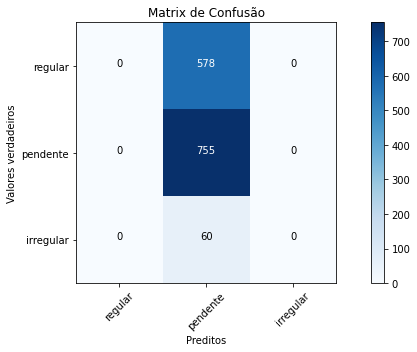

In [29]:
fig = plt.figure(figsize=(10, 5)) 
yp = model.predict(x_test)
cm=confusion_matrix(y_test, yp)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm, classes=['regular', 'pendente', 'irregular'])

In [30]:
print(classification_report(y_test, yp))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       578
         1.0       0.54      1.00      0.70       755
         2.0       0.00      0.00      0.00        60

    accuracy                           0.54      1393
   macro avg       0.18      0.33      0.23      1393
weighted avg       0.29      0.54      0.38      1393



In [31]:
model_win = models[1][1]
model_win

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=-1,
                   penalty='l2', random_state=1024, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

In [32]:
variaveis= x.columns.to_list()
variaveis

['1.1',
 '1.3',
 '1.4',
 '1.5',
 '2.1.1',
 '2.1.2',
 '3.1',
 '3.2.2',
 '3.2.3',
 '3.3',
 '3.4',
 '3.5',
 '4.1',
 '4.2',
 '4.3',
 '4.4',
 'qtd_2018_x',
 'idhm']

Validação

In [33]:
novo_munic = [[0,1,2,2,1,1,1,0,0,1,2,2,1,1,1,0,350000, 0.654]]
y = model_win.predict(np.array(novo_munic))
y[0]

1.0

12) CLUSTERIZAÇÃO - AGRUPAMENTO:

12.1) Seleção das colunas utilizadas no Modelo

In [34]:
cols = ['cod_mun_ent',
'qtd_2018_x', #populacao
'idhm',
'idhm_renda',
'soma_capag',
'media_indicadores',
'mediana_indicadores',
'sit_obr'] 
y= dfr_fpm['sit_obr']
x= dfr_fpm[cols[1:-1]]

12.2) Pré-agrupamento - Normalização

In [35]:
scaler = StandardScaler()
dfr_fpm_sca = scaler.fit_transform(x)

12.3) Agrupamento

In [36]:
n=3

In [37]:
model_km = kmeans(init='k-means++', n_clusters=n, n_init=10)
model_km.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

12.4) Centróides dos Grupos

In [38]:
centroids = model_km.cluster_centers_
labels = model_km.labels_
print(centroids)
print(labels)

[[3.86e+04 6.58e-01 6.42e-01 2.19e+11 7.31e+10 4.88e-01]
 [9.10e+03 6.72e-01 6.93e-01 9.02e+15 3.01e+15 7.72e-02]
 [1.03e+04 7.27e-01 6.95e-01 1.14e+16 3.80e+15 1.77e-01]]
[0 0 0 ... 0 0 0]


12.5) Avaliação dos k grupos pelo método de Elbow

1 3.2627210102549044e+32
2 5.856892131208392e+30
3 1.6853230202657765e+30
4 2.9033057691355567e+28
5 2.9033057691355444e+28
6 2.903305769135545e+28
7 2.903305769135542e+28
8 2.903305769135544e+28
9 2.903305769135547e+28
10 2.9033057691355426e+28


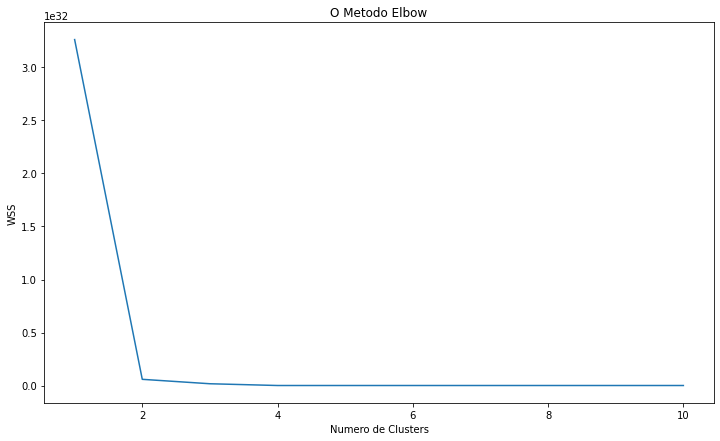

In [39]:
plt.figure(figsize=(12, 7))
wcss = []
for i in range(1, 11):
    kmeans_elbow = kmeans(n_clusters = i, init = 'random')
    kmeans_elbow.fit(x)
    print(i,kmeans_elbow.inertia_)
    wcss.append(kmeans_elbow.inertia_)  
plt.plot(range(1, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

12.6) Distribuição dos Grupos

In [40]:
dfr_fpm['grupos'] = np.array(labels)

In [41]:
dfr_fpm.grupos.value_counts()

0    5566
1       2
2       1
Name: grupos, dtype: int64

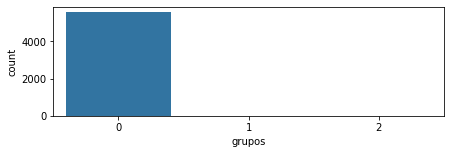

In [42]:
plt.figure(figsize=(7, 2))
sb.countplot(x ='grupos', data = dfr_fpm)

In [43]:
dfr_g0 = dfr_fpm[dfr_fpm['grupos'] ==0] 
print('Total de Municípios do Grupo 0:{0}'.format(len(dfr_g0)))
dfr_g0

Total de Municípios do Grupo 0:5566


,cod_mun_ent,uf,nom_municipio_x,1.1,1.3,1.4,1.5,2.1.1,2.1.2,3.1,3.2.2,3.2.3,3.3,3.4,3.5,4.1,4.2,4.3,4.4,qtd_2018_x,Região,idhm,idhm_renda,soma_capag,media_indicadores,mediana_indicadores,sit_obr,grupos
0,520005.0,GO,Abadia de Goi�s,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,8583,CO,0.708,0.687,1.9967,0.665567,0.9063,1.0,0
1,310010.0,MG,Abadia dos Dourados,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6972,SE,0.689,0.693,1.8503,0.616767,0.7747,0.0,0
2,520010.0,GO,Abadi�nia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19614,CO,0.689,0.671,2.9462,0.982067,0.9592,0.0,0
3,310020.0,MG,Abaet�,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23223,SE,0.698,0.720,1.3460,0.448667,0.3102,0.0,0
4,150010.0,PA,Abaetetuba,2.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0,2.0,156292,N,0.628,0.579,0.0000,0.000000,0.0000,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5564,293360.0,BA,Xique-Xique,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46440,NE,0.585,0.563,7.3226,2.440867,1.0266,0.0,0
5565,251740.0,PB,Zabel�,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2225,NE,0.623,0.567,1.1971,0.399033,0.1567,1.0,0
5566,355715.0,SP,Zacarias,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2684,SE,0.729,0.695,0.8510,0.283667,0.0021,0.0,0
5567,211400.0,MA,Z� Doca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,51471,NE,0.595,0.559,1.0801,0.360033,0.2006,1.0,0


In [44]:
dfr_g1 = dfr_fpm[dfr_fpm['grupos'] ==1] 
print('Total de Municípios do Grupo 1:{0}'.format(len(dfr_g1)))
dfr_g1

Total de Municípios do Grupo 1:2


,cod_mun_ent,uf,nom_municipio_x,1.1,1.3,1.4,1.5,2.1.1,2.1.2,3.1,3.2.2,3.2.3,3.3,3.4,3.5,4.1,4.2,4.3,4.4,qtd_2018_x,Região,idhm,idhm_renda,soma_capag,media_indicadores,mediana_indicadores,sit_obr,grupos
1024,410442.0,PR,Cand�i,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15903,S,0.635,0.655,8.901839e+15,2.967280e+15,0.0507,0.0,1
3672,431413.0,RS,Paulo Bento,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2287,S,0.710,0.730,9.130442e+15,3.043481e+15,0.1038,0.0,1


In [45]:
dfr_g2 = dfr_fpm[dfr_fpm['grupos'] ==2] 
print('Total de Municípios do Grupo 2:{0}'.format(len(dfr_g2)))
dfr_g2

Total de Municípios do Grupo 2:1


,cod_mun_ent,uf,nom_municipio_x,1.1,1.3,1.4,1.5,2.1.1,2.1.2,3.1,3.2.2,3.2.3,3.3,3.4,3.5,4.1,4.2,4.3,4.4,qtd_2018_x,Região,idhm,idhm_renda,soma_capag,media_indicadores,mediana_indicadores,sit_obr,grupos
4681,412480.0,PR,S�o Jo�o,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10303,S,0.727,0.695,1.138924e+16,3.796414e+15,0.1769,1.0,2
